In [37]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.sparse import csr_matrix
import cooler
import time
from sklearn.decomposition import PCA
import glob
import pyBigWig

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../../source/")
sys.path.insert(0, source_path)
print(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central


# hyperlocal imports
import core_utils
import nb_utils as nb
import homocore as homoc

/home/machoi/higher-order-single-cell/source


In [47]:
def generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes,
                                      edge_probability_core, edge_probability_periphery,
                                      avg_edge_size, core_periphery_probability):
    """
    This function generates a random hypergraph with a core-periphery structure and creates its binary incidence matrix.

    Args:
      num_core_nodes: Number of nodes in the core.
      num_periphery_nodes: Number of nodes in the periphery.
      edge_probability_core: Probability of an edge forming between core nodes.
      edge_probability_periphery: Probability of an edge forming between periphery nodes.
      avg_edge_size: Average number of nodes per edge.
      core_periphery_probability: Probability of an edge forming between a core node and a periphery node.

    Returns:
      A tuple containing four elements:
          * core_nodes: List of core nodes.
          * periphery_nodes: List of periphery nodes.
          * edges: List of edges.
          * incidence_matrix: Binary incidence matrix as a NumPy array.
    """

    # Define core and periphery nodes
    core_nodes = list(range(num_core_nodes))
    periphery_nodes = list(range(num_core_nodes, num_core_nodes + num_periphery_nodes))

    # Get total number of nodes
    total_nodes = len(core_nodes) + len(periphery_nodes)

    # Generate edges
    edges = []
    for _ in range(int(len(core_nodes) * edge_probability_core)):
        # Sample core nodes for an edge
        edge = random.sample(core_nodes, k=int(avg_edge_size))
        edges.append(edge)

    for _ in range(int(len(periphery_nodes) * edge_probability_periphery)):
        # Sample periphery nodes for an edge
        edge = random.sample(periphery_nodes, k=int(avg_edge_size))
        edges.append(edge)

    # Add edges between core and periphery nodes
    for _ in range(int(num_core_nodes * num_periphery_nodes * core_periphery_probability)):
        # Sample a core node and a periphery node
        core_node = random.choice(core_nodes)
        periphery_node = random.choice(periphery_nodes)
        # Create an edge with the core and periphery node
        edge = [core_node, periphery_node]
        # Optionally, you can sample additional nodes for the edge
        if avg_edge_size > 2:
            additional_nodes = random.sample(core_nodes + periphery_nodes, k=int(avg_edge_size) - 2)
            edge.extend(additional_nodes)
            
        edges.append(edge)

    # Create empty matrix
    incidence_matrix = np.zeros((total_nodes, len(edges)), dtype=int)

    # Fill the matrix with 1s for corresponding nodes in each edge
    for i, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node, i] = 1

    return core_nodes, periphery_nodes, edges, incidence_matrix

# Example usage
num_core_nodes = 3
num_periphery_nodes = 9
edge_probability_core = 0.9
edge_probability_periphery = 0.2
avg_edge_size = 3
core_periphery_probability = 0.1

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

print(type(incidence_matrix))
H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
H

<class 'numpy.ndarray'>
H.shape=(12, 5)


,0,1,2,3,4
0,1,1,0,0,0
1,1,1,0,1,0
2,1,1,0,0,1
3,0,0,0,0,0
4,0,0,1,0,0
5,0,0,0,0,0
6,0,0,0,1,0
7,0,0,1,1,1
8,0,0,0,0,0
9,0,0,0,0,0


Text(0.5, 0, 'Hyperedges')

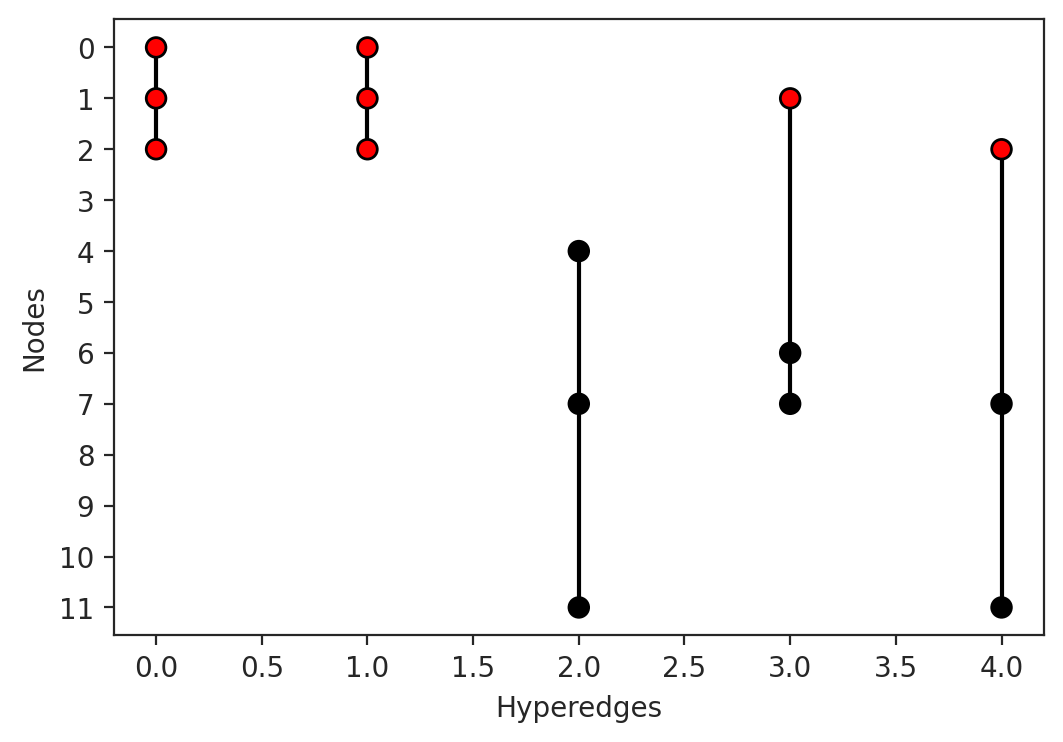

In [48]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

for i, column in enumerate(H.columns):
    hyperedge = H[column][H[column] > 0]
    order = len(hyperedge)
    x_ind = np.ones(order) * i
    
    c = np.where(hyperedge.index.isin(core_nodes), 'r', 'k')

    # Plot nodes
    plt.scatter(x_ind, 
                hyperedge.index, 
                s=50,
                c=c, 
                ec='k',
                zorder=3)

    # Plot edges
    plt.plot(x_ind, 
             hyperedge.index,
             c='k') 
    
plt.yticks(range(H.shape[0]))
plt.gca().invert_yaxis()
plt.ylabel('Nodes')
plt.xlabel('Hyperedges')

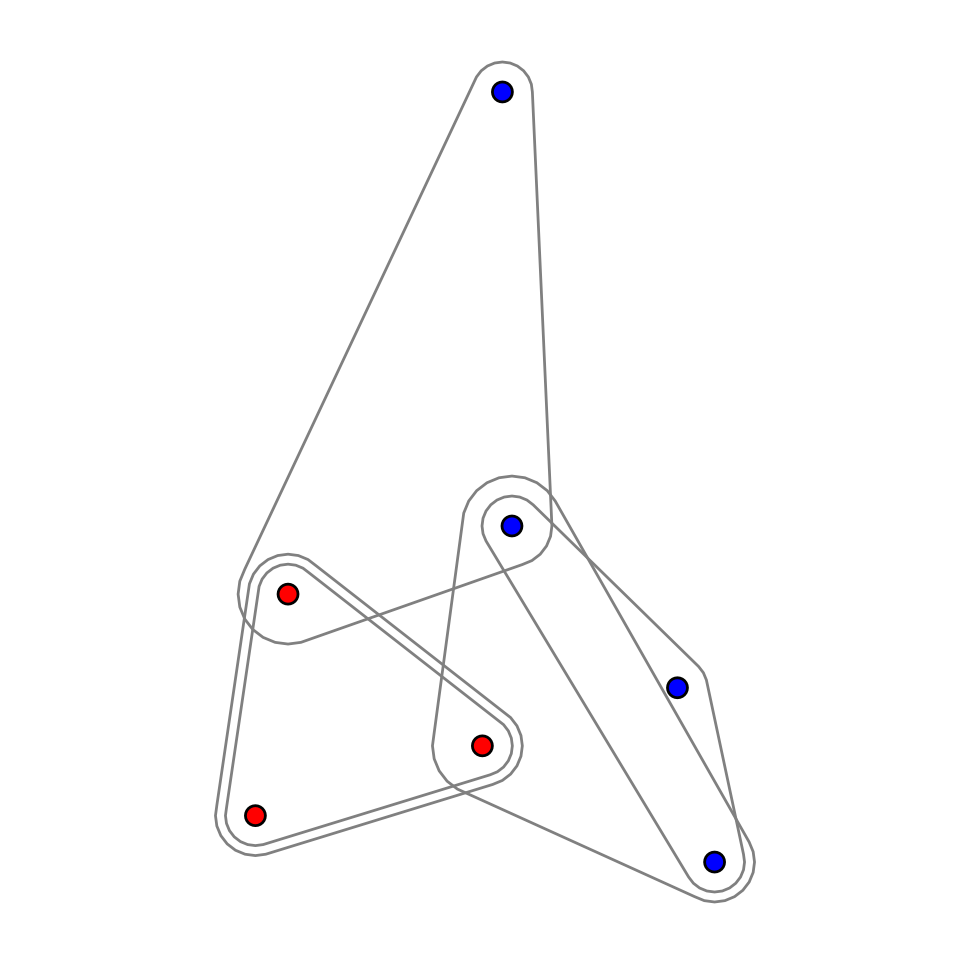

In [49]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx] = tuple(row[row == 1].index)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )

In [20]:
def get_core(H, outlier_indices, function='log-exp', q=0.75, maxiter=10000):
    """
    Calculates nonlinear eigenvector centrality and related metrics.

    Args:
        H: The adjacency matrix (pandas DataFrame).
        outlier_indices: List of indices to drop from H.
        function: Nonlinear function for centrality calculation (default: 'log-exp').
        q: Quantile threshold for defining 'core' nodes (default: 0.75).
        maxiter: Maximum iterations for centrality calculation.

    Returns:
        pandas.DataFrame: A DataFrame with node information and centrality metrics.
    """
    
    # Remove outliers and zero-sum columns (without explicit checks)
    Hhat = H.drop(outlier_indices).loc[:, (H.sum(axis=0) != 0)]

    # Calculate centrality using NetworkX
    nodes_cent, _ = central.nonlinear_eigenvector_centrality(
        Hhat, 
        function=function, 
        maxiter=maxiter,
    )

    # Create DataFrame with results
    nodes = pd.DataFrame({
        'local_bin': Hhat.index,
        'node_centrality': nodes_cent,
        'zscores': stats.zscore(nodes_cent),
        'node_centrality_norm': nb.min_max(nodes_cent),  # Assuming you have ut.min_max elsewhere
        'core' : nodes_cent >= np.quantile(nodes_cent, q),
    })

    return nodes

[[1 1 0 0 0]
 [1 1 0 1 0]
 [1 1 0 0 1]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 1]]
7
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 4)	1
  (4, 5)	1
  (5, 6)	1
  (6, 3)	1
4 [[1 1 0 0 0]
 [1 1 0 1 0]
 [1 1 1 0 0]
 [0 0 0 1 0]
 [0 0 1 1 1]
 [0 0 1 0 1]
 [0 0 0 0 1]]


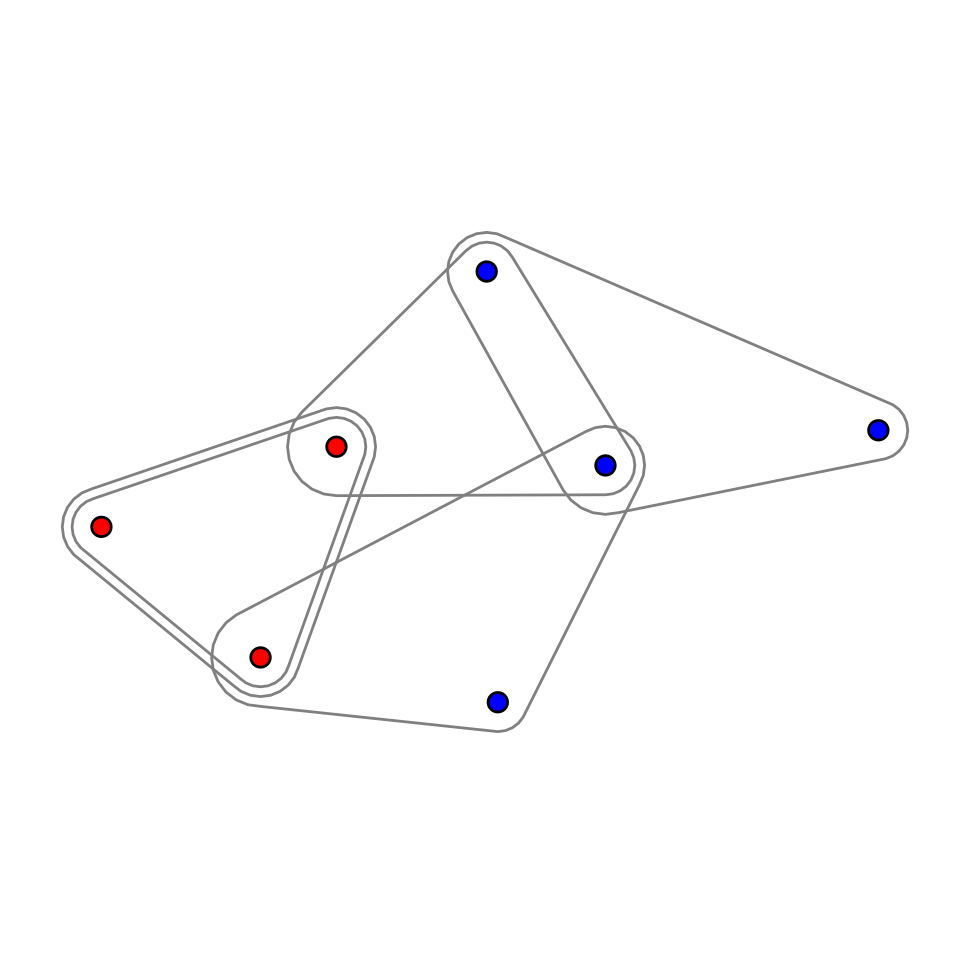

In [88]:
incidence_matrix = H.to_numpy()
df_centrality = homoc.get_core(H, [])
centrality_dict = df_centrality['node_centrality'].to_dict()
print(incidence_matrix)
G = csr_matrix(remove_zero_rows(sorted_incidence_matrix(incidence_matrix,centrality_dict)))
num_nodes = G.shape[0]
print(num_nodes)
M = sp.identity(num_nodes, format='csr') 
C = G[:, 0]

#for j in range(1, num_nodes):
for j in range(0,1):
    M = generate_random_permutation_matrix(num_nodes, [(0,0), (1,1), (2,2)])
    print(M)
    fake_core = M.dot(G)
    dense_matrix = fake_core.toarray()
    rank = np.linalg.matrix_rank(dense_matrix)
    print(rank, dense_matrix)


newH = pd.DataFrame(dense_matrix)
hx = to_hypernet(newH)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )

In [54]:
import numpy as np
from scipy.sparse import csr_matrix

def generate_random_permutation_matrix(size, fixed_entries):
    """
    Generates a random sparse permutation matrix with certain entries fixed.

    Parameters:
    - size (int): The size of the permutation matrix (size x size).
    - fixed_entries (list of tuples): List of (row, column) tuples specifying fixed positions with a `1`.

    Returns:
    - scipy.sparse.csr_matrix: The resulting sparse permutation matrix in CSR format.
    """
    if len(fixed_entries) > size:
        raise ValueError("Number of fixed entries cannot exceed matrix size")

    # Initialize the permutation matrix
    matrix = np.zeros((size, size), dtype=int)
    
    # Set fixed entries
    for row, col in fixed_entries:
        matrix[row, col] = 1
    
    # Create lists of free rows and columns
    fixed_rows = set(row for row, _ in fixed_entries)
    fixed_cols = set(col for _, col in fixed_entries)
    
    free_rows = [i for i in range(size) if i not in fixed_rows]
    free_cols = [i for i in range(size) if i not in fixed_cols]
    
    # Shuffle free rows and columns to create random permutation
    np.random.shuffle(free_rows)
    np.random.shuffle(free_cols)
    
    # Create a mapping for the remaining entries
    for i, row in enumerate(free_rows):
        col = free_cols[i]
        matrix[row, col] = 1
    
    # Convert to CSR format
    sparse_matrix = csr_matrix(matrix)
    
    return sparse_matrix

# Example usage
size = 5
fixed_entries = [(0, 0), (1, 2), (3, 4)]  # Fixed positions for `1`s

sparse_perm_matrix = generate_random_permutation_matrix(size, fixed_entries)
print("Sparse Permutation Matrix in CSR format:\n", sparse_perm_matrix)
print("Dense form:\n", sparse_perm_matrix.toarray())


Sparse Permutation Matrix in CSR format:
   (0, 0)	1
  (1, 2)	1
  (2, 3)	1
  (3, 4)	1
  (4, 1)	1
Dense form:
 [[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 1 0 0 0]]


In [64]:
import numpy as np
from scipy.sparse import csr_matrix

def get_non_zero_coordinates(sparse_matrix):
    """
    Extracts the coordinates of non-zero elements from a sparse CSR matrix.

    Parameters:
    - sparse_matrix (scipy.sparse.csr_matrix): The sparse matrix in CSR format.

    Returns:
    - list of tuples: List of (row, column) tuples representing the coordinates of non-zero elements.
    """
    # Extract row and column indices
    rows, cols = [], []
    
    # Iterate over each row
    for row in range(sparse_matrix.shape[0]):
        start_idx = sparse_matrix.indptr[row]
        end_idx = sparse_matrix.indptr[row + 1]
        rows.extend([row] * (end_idx - start_idx))
        cols.extend(sparse_matrix.indices[start_idx:end_idx])
    
    return list(zip(rows, cols))

# Example usage
dense_matrix = np.array([[0, 0, 1],
                         [4, 0, 0],
                         [0, 5, 6]])

# Convert to CSR format
sparse_matrix = csr_matrix(dense_matrix)

# Get non-zero coordinates
coordinates = get_non_zero_coordinates(sparse_matrix)
print("Non-zero coordinates:", coordinates)

coordinates[0][0]

Non-zero coordinates: [(0, 2), (1, 0), (2, 1), (2, 2)]


0

In [32]:
import numpy as np

def sorted_incidence_matrix(incidence_matrix, centrality_dict):
    """
    Returns a new incidence matrix sorted by decreasing pseudo centrality of hyperedges.

    This function computes a pseudo centrality score for each hyperedge in the hypergraph by summing the centrality values
    of its incident nodes. It then rearranges the incidence matrix columns based on these scores in descending order.

    Parameters:
    - incidence_matrix (numpy.ndarray): A 2D NumPy array where rows represent nodes and columns represent hyperedges.
      The entries are `1` if the node is incident to the hyperedge and `0` otherwise.
    - centrality_dict (dict): A dictionary mapping nodes to their centrality values. Centrality values should be
      numerical. If a node is not present in the dictionary, a default value of 0 is used.

    Returns:
    - numpy.ndarray: The new incidence matrix with columns sorted in descending order of pseudo centrality scores.

    Example:
    >>> incidence_matrix = np.array([[1, 1, 0, 0],
    >>>                               [0, 1, 1, 0],
    >>>                               [0, 0, 1, 1]])
    >>> centrality_dict = {0: 0.5, 1: 1.2, 2: 0.9}
    >>> new_incidence_matrix = sorted_incidence_matrix(incidence_matrix, centrality_dict)
    >>> print(new_incidence_matrix)
    """
    num_nodes, num_hyperedges = incidence_matrix.shape
    
    # Calculate pseudo centrality scores for each hyperedge (column)
    hyperedge_centralities = {}
    for j in range(num_hyperedges):
        nodes = np.where(incidence_matrix[:, j] == 1)[0]
        # Sum centrality values of all nodes incident to the hyperedge
        pseudo_centrality = sum(centrality_dict.get(node, 0) for node in nodes)
        hyperedge_centralities[j] = pseudo_centrality
    
    # Sort hyperedges by pseudo centrality in descending order
    sorted_hyperedges_indices = sorted(hyperedge_centralities, key=hyperedge_centralities.get, reverse=True)
    
    # Reorder the incidence matrix columns based on sorted hyperedge indices
    sorted_incidence_matrix = incidence_matrix[:, sorted_hyperedges_indices]
    
    return sorted_incidence_matrix


def remove_zero_rows(matrix):
    """
    Removes rows from a NumPy array where all elements are zero.

    Parameters:
    - matrix (numpy.ndarray): A 2D NumPy array.

    Returns:
    - numpy.ndarray: A new NumPy array with rows containing only zeros removed.
    """
    # Check which rows have all zero values
    non_zero_rows = np.any(matrix != 0, axis=1)
    
    # Filter out the zero rows
    filtered_matrix = matrix[non_zero_rows]
    
    return filtered_matrix

# Example usage
matrix = np.array([[0, 0, 0],
                   [1, 2, 3],
                   [0, 0, 0],
                   [4, 5, 6]])

filtered_matrix = remove_zero_rows(matrix)
print("Filtered matrix:\n", filtered_matrix)



Filtered matrix:
 [[1 2 3]
 [4 5 6]]
